# Simulatingggggggggg

In the [last notebook](./artefacts-2-compensation.ipynb), 

## Pipette in the bath

We start by modelling a pipette hanging in the bath, but not touching a cell.
We've found a cell and brought the pipette close, but not near enough to affect the current reading yet.

We'll assume that $R_s$ is the pipette tip resistance, and is $5M\Omega$.
The capacitance will probably be a bit less than when the pipette is fully submerged, but we'll leave it at the 5pF value used throughout.
The variables representing the cell have been removed, and all compensations are off at this point, so we won't include them either.

In [1]:
import colorsys
import myokit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
m = myokit.parse_model('''
[[model]]
amp.Vp = 0
amp.Vo = 0

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
Rs = 5e-3 [GOhm] in [GOhm]
Cp = 5 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
I = 0 [pA] in [pA]
E_off = 12 [mV] in [mV]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp + E_off) / Rs + Cf * dot(Vo)) / (Cf + Cp)
    in [mV]
dot(Vo) = (Vc - Vp) / tau_amp
    in [mV]
I_obs = (Vo - Vc) / Rf
    in [pA]
''')
m.check_units(myokit.UNIT_STRICT)

In [3]:
p = myokit.Protocol()
p.add_step(level=0, duration=5)
p.add_step(level=10, duration=10)
p.add_step(level=0, duration=15)

s = myokit.Simulation(m, p)
s.pre(4)
d = s.run(20, log_interval=1e-3)

In [4]:
def create_plot(label1='Vp (mV)', label2='Iobs (pA)', av1=[], av2=[]):
    kw = dict(color='#aaa', ls='--')
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_ylabel(label1)
    for y in av1:
        ax1.axhline(y, **kw)
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel(label2)
    for y in av2:
        ax2.axhline(y, **kw)
    
    return fig, ax1, ax2

blue_hls = colorsys.rgb_to_hls(*matplotlib.colors.ColorConverter.to_rgb('tab:blue'))
def blue(f):
    h, l, s = blue_hls
    return colorsys.hls_to_rgb(
        blue_hls[0], 1 - f * (1 - blue_hls[1]), blue_hls[2])

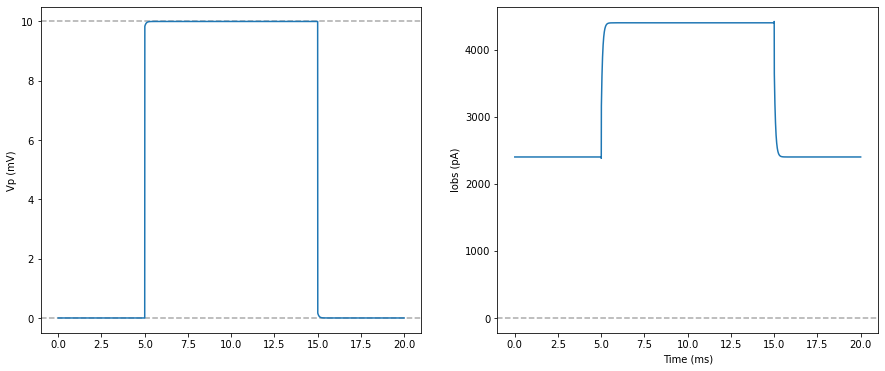

In [5]:
fig, ax1, ax2 = create_plot(av1=[0, 10], av2=[0])
ax1.plot(d.time(), d['amp.Vp'])
ax2.plot(d.time(), d['amp.I_obs'])
plt.show()

The first thing we need to do is zero the current.

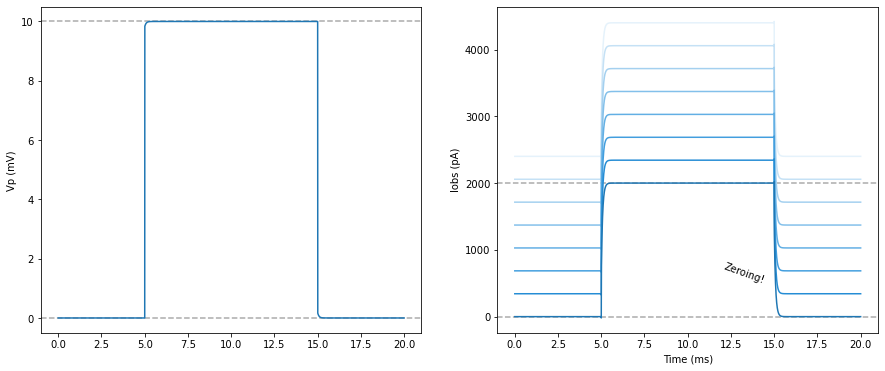

In [6]:
fig, ax1, ax2 = create_plot(av1=[0, 10], av2=[0, 2000])
for E in np.linspace(12, 0, 8):
    s.reset()
    s.set_constant('amp.E_off', E)
    s.pre(4)
    d = s.run(20, log_interval=1e-3)
    ax2.plot(d.time(), d['amp.I_obs'], color=blue(1 - 0.9 * (E / 12)))
ax1.plot(d.time(), d['amp.Vp'])
ax2.text(12, 500, 'Zeroing!', rotation=-20)
plt.show()

Let's look at the result:

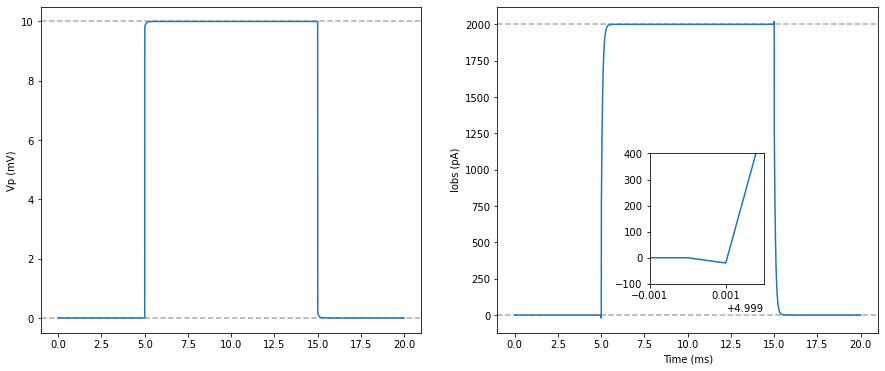

In [7]:
fig, ax1, ax2 = create_plot(av1=[0, 10], av2=[0, 2000])
ax1.plot(d.time(), d['amp.Vp'])
ax2.plot(d.time(), d['amp.I_obs'])
ins = ax2.inset_axes((0.4, 0.15, 0.3, 0.4))
ins.plot(d.time(), d['amp.I_obs'])
ins.set_xlim(4.998, 5.001)
ins.set_ylim(-100, 400)
plt.show()

On the left, we see that the pipette voltage follows the command voltage rapidly.

On the right, we see a current of either 0 or 10mV / 5MOhm = 2nA.
It rises and falls rapidly, hindered only by the charging of $C_f$.
A very slight dip can be seen just before the voltage increase, as $V_c$ briefly exceeds $V_o$ before the amplifier rapidly catches up.
Note that we do not yet see strong capacitative transients at this point.

### Intermezzo: Why aren't the edges quite straight?

We can check that $R_fC_f$ dictates the steepness of the current response by increasing $C_f$:

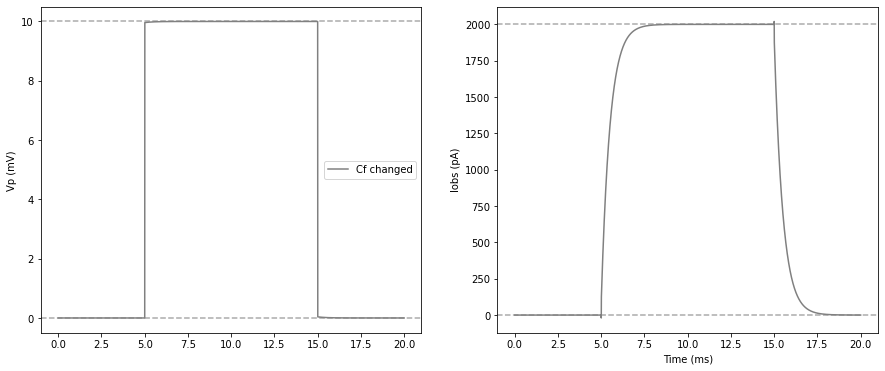

In [8]:
s.reset()
s.set_constant('amp.Cf', 1)
d = s.run(20, log_interval=1e-3)
s.set_constant('amp.Cf', 0.15)

fig, ax1, ax2 = create_plot(av1=(0, 10), av2=(0, 2000))
ax1.plot(d.time(), d['amp.Vp'], color='gray', label='Cf changed')
ax2.plot(d.time(), d['amp.I_obs'], color='gray')
ax1.legend()
plt.show()

Note that we see a significant change to the current, but the voltage is mostly unaffected.
By contrast, if we use a slower measuring op-amp, both signals show a delay:

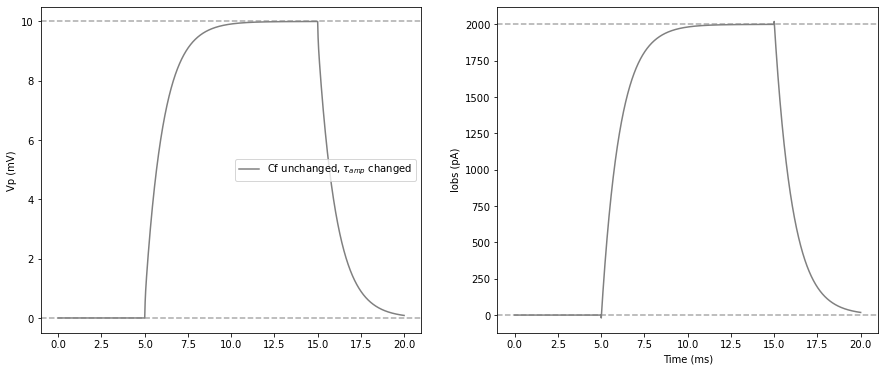

In [9]:
s.reset()

s.set_constant('amp.tau_amp', 1e-2)
d = s.run(20, log_interval=1e-3)
s.set_constant('amp.tau_amp', 20e-6)

fig, ax1, ax2 = create_plot(av1=(0, 10), av2=(0, 2000))
ax1.plot(d.time(), d['amp.Vp'], color='gray', label='Cf unchanged, $\\tau_{amp}$ changed')
ax2.plot(d.time(), d['amp.I_obs'], color='gray')
ax1.legend()
plt.show()

## Touching the cell

Now, we gently move the pipette against the cell membrane.
This blocks the pipette opening, increasing the access resistance greatly.
We'll assume it goes up to 200MOhm, and use the same model as above.

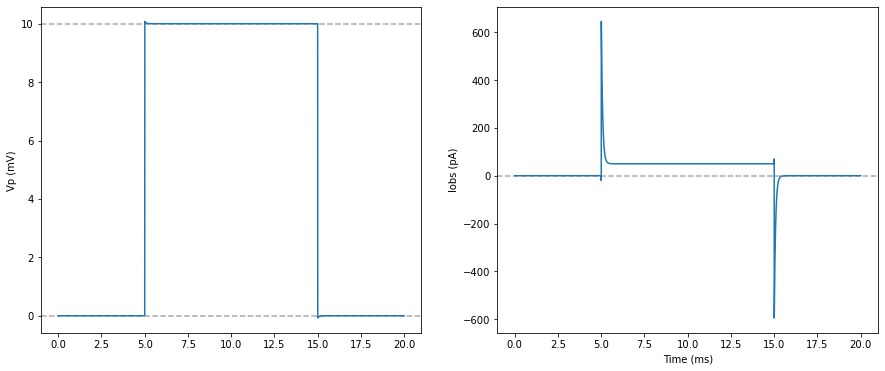

In [10]:
s.reset()
s.set_constant('amp.Rs', 0.2)
d = s.run(20, log_interval=1e-3)
fig, ax1, ax2 = create_plot(av1=[0, 10], av2=[0])
ax1.plot(d.time(), d['amp.Vp'])
ax2.plot(d.time(), d['amp.I_obs'])
plt.show()

With this new high resistance, the fast-capacitance artefacts become clearly visible.

## A giga-ohm seal

We apply more virtual suction, and create a giga-ohm seal. Let's use 2GOhm.

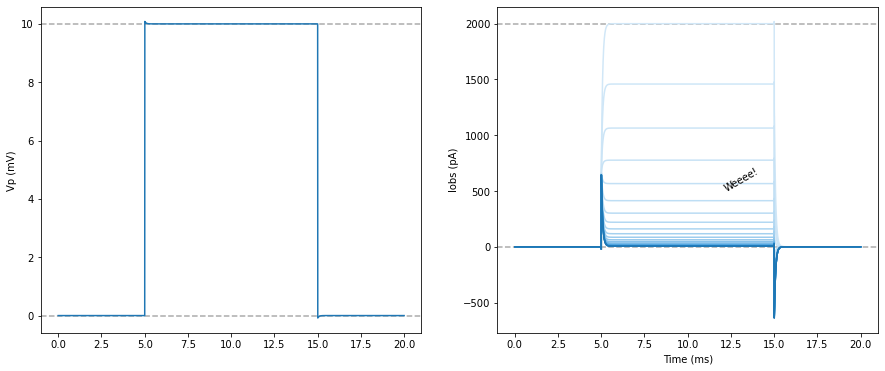

In [11]:
fig, ax1, ax2 = create_plot(av1=[0, 10], av2=[0, 2000])
for Rs in np.geomspace(5e-3, 2, 20):
    s.reset()
    s.set_constant('amp.Rs', Rs)
    d = s.run(20, log_interval=1e-3)
    ax2.plot(d.time(), d['amp.I_obs'], color=blue(0.1 + 0.9 * (Rs / 2)**0.4))
ax1.plot(d.time(), d['amp.Vp'])
ax2.plot(d.time(), d['amp.I_obs'], color='tab:blue')
ax2.text(12, 500, 'Weeee!', rotation=30)
plt.show()

## Fast transient cancellation

At this point we zoom in a bit, and get ready to switch the fast capacitance compensation on.

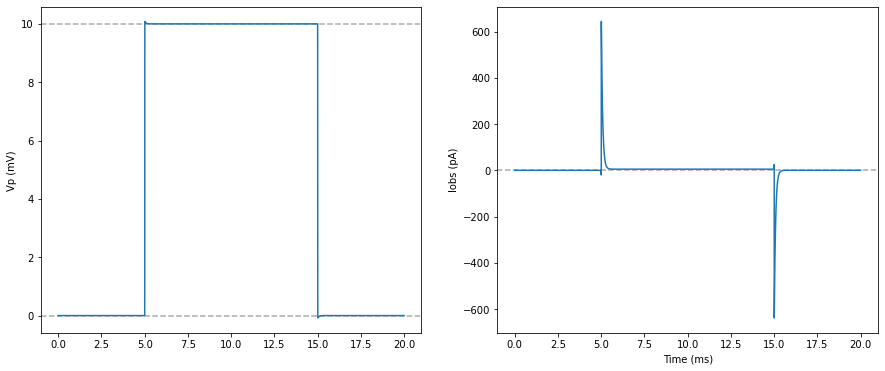

In [12]:
fig, ax1, ax2 = create_plot(av1=[0, 10], av2=[0])
ax1.plot(d.time(), d['amp.Vp'])
ax2.plot(d.time(), d['amp.I_obs'])
plt.show()

To do this, we need to add in the fast capacitance filtering, as well as the filtered $V_\text{ref}$ it takes as input.

In [13]:
m = myokit.parse_model('''
[[model]]
amp.Vp = 0
amp.Vo = 0
amp.Vr = 0

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
Rs = 2 [GOhm] in [GOhm]
Cp = 5 [pF] in [pF]
Cp_est = 5 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
tau_sum = 10e-3 [ms] in [ms]
I = 0 [pA] in [pA]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - Vp / Rs + Cf * dot(Vo) + Cp_est * dot(Vr)) / (Cf + Cp)
    in [mV]
dot(Vo) = (Vr - Vp) / tau_amp
    in [mV]
dot(Vr) = (Vc - Vr) / tau_sum
    in [mV]
I_obs = (Vo - Vc) / Rf
    in [pA]  
''')
m.check_units(myokit.UNIT_STRICT)

In [14]:
s = myokit.Simulation(m, p)
s.pre(4)

Because it's hard to pick just one zoom level, we will show $I_\text{obs}$ both left and right!

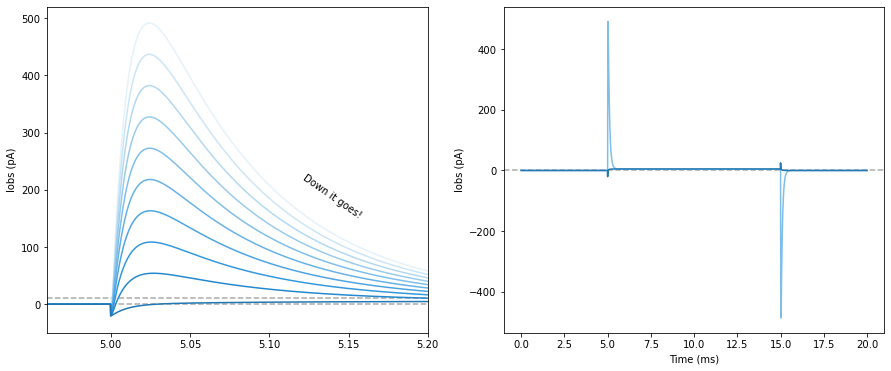

In [15]:
fig, ax1, ax2 = create_plot(av1=[0, 10], av2=[0], label1='Iobs (pA)')
for Cp_est in np.linspace(0, 5, 10):
    s.reset()
    s.set_constant('amp.Cp_est', Cp_est)
    d = s.run(20, log_interval=1e-4).npview()
    ax1.plot(d.time(), d['amp.I_obs'], color=blue(0.1 + 0.9 * Cp_est / 5))
    if Cp_est == 0:
        ax2.plot(d.time(), d['amp.I_obs'], color=blue(0.5))
ax1.set_xlim(4.96, 5.2)
ax1.set_ylim(-50, 520)
ax1.text(5.12, 150, 'Down it goes!', rotation=-35)
ax2.plot(d.time(), d['amp.I_obs'], color=blue(1))
plt.show()

The end result looks something like this:

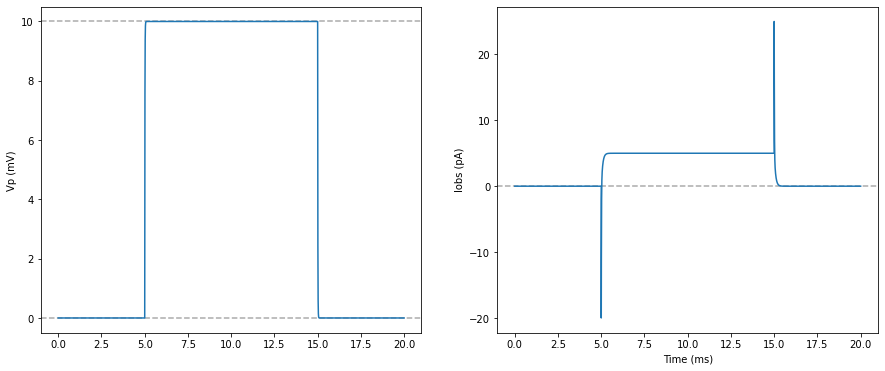

In [16]:
fig, ax1, ax2 = create_plot(av1=[0, 10], av2=[0])
ax1.plot(d.time(), d['amp.Vp'])
ax2.plot(d.time(), d['amp.I_obs'])
plt.show()

### Intermezzo: What's left is not a capacitance artefact

The remaining spikes are not due to the parasitic capacitance, but arise because of the different delays in the amplifier.
We can show this in the simulation by setting $C_p$ and its estimate $C_p^*$ to 0.

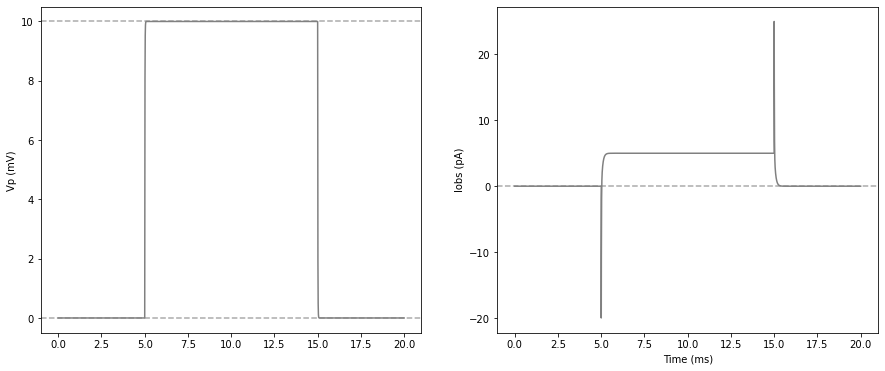

In [17]:
s.reset()
s.set_constant('amp.Cp', 0)
s.set_constant('amp.Cp_est', 0)
d = s.run(20, log_interval=1e-4).npview()

fig, ax1, ax2 = create_plot(av1=[0, 10], av2=[0])
ax1.plot(d.time(), d['amp.Vp'], color='gray')
ax2.plot(d.time(), d['amp.I_obs'], color='gray')
plt.show()

### Intermezzo: Noise and filtering

If this doesn't look very familiar, it may be because we haven't simulated any noise...

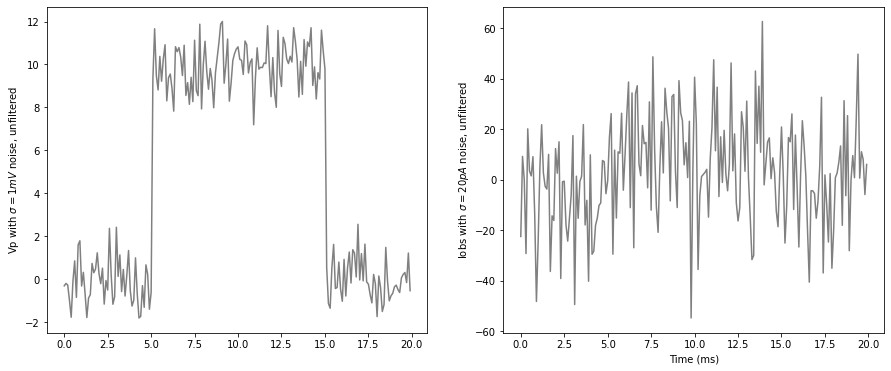

In [18]:
s.reset()
s.set_constant('amp.Cp', 5)
s.set_constant('amp.Cp_est', 5)
d = s.run(20, log_interval=0.1).npview()  # Sample at 10 kHz

t = d.time()
vp = d['amp.Vp'] + np.random.normal(0, 1, t.shape)
iobs = d['amp.I_obs'] + np.random.normal(0, 20, t.shape)

fig, ax1, ax2 = create_plot(
    label1='Vp with $\sigma=1mV$ noise, unfiltered',
    label2='Iobs with $\sigma=20pA$ noise, unfiltered')
ax1.plot(t, vp, color='gray')
ax2.plot(t, iobs, color='gray')
plt.show()

Of course, we didn't simulate any filtering either...

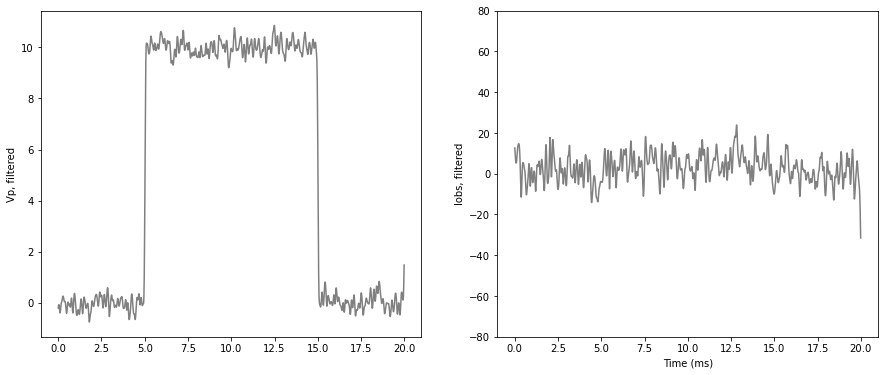

In [19]:
# Simulate, with sampling at 100kHz
s.reset()
d = s.run(20, log_interval=0.01).npview()

# Add noise
t = d.time()
vp = d['amp.Vp'] + np.random.normal(0, 1, t.shape)
iobs = d['amp.I_obs'] + np.random.normal(0, 20, t.shape)

# Filter it out again
import scipy.signal

def low_pass(data, w, f, n=3):
    """ Apply an order-n Bessel low-pass filter with cut-off w (in Hz). """
    w = w / (f / 2)
    b, a = scipy.signal.bessel(n, w, btype='lowpass')
    return scipy.signal.filtfilt(b, a, data)

dt = 0.01
f = 1 / dt     # Sampling frequency, in kHz
w = 10         # Cut-off frequency, in kHz

fig, ax1, ax2 = create_plot(label1='Vp, filtered', label2='Iobs, filtered')
ax2.set_ylim(-80, 80)
ax1.plot(t, low_pass(vp, w, f, 6), color='gray')
ax2.plot(t, low_pass(iobs, w, f, 6), color='gray')
plt.show()

We these additions, the step response looks a lot more like a straight line.

## Breaking the seal: access to the cell

Next, we break the seal and gain access to the cell.
To simulate this, we need the full model.

To make it a bit more interesting, we'll add a model cell with a membrane resistance of 500M$\Omega$ and a capacitance of 25 pF.

In [20]:
m = myokit.parse_model('''
[[model]]
amp.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
alpha = 0
beta = 0
Rs = 15e-3 [GOhm] in [GOhm]
Rs_est = 15e-3 [GOhm] in [GOhm]
Rm = 0.5 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 0 [pF] in [pF]
Cp = 5 [pF] in [pF]
Cp_est = 5 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
tau_sum = 10e-3 [ms] in [ms]
tau_est = if(val < 1e-8 [ms], 1e-8 [ms], val)
    in [ms]
    val = (1 - beta) * Rs_est * Cm_est
        in [ms]
I = Vm / Rm
    in [pA]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp - Vm) / Rs +
            Cf * dot(Vo) + Cm * dot(Ve) + Cp * dot(Vr)
          ) / (Cp + Cf)
    in [mV]
dot(Vo) = (Vr - Vp) / tau_amp
    in [mV]
dot(Ve) = (Vc - Ve) / tau_est
    in [mV]
dot(Vr) = (Vc + alpha * Rs_est * I_obs + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum
    in [mV]
I_obs = (Vo - Vr) / Rf
    in [pA]
''')
m.check_units(myokit.UNIT_STRICT)

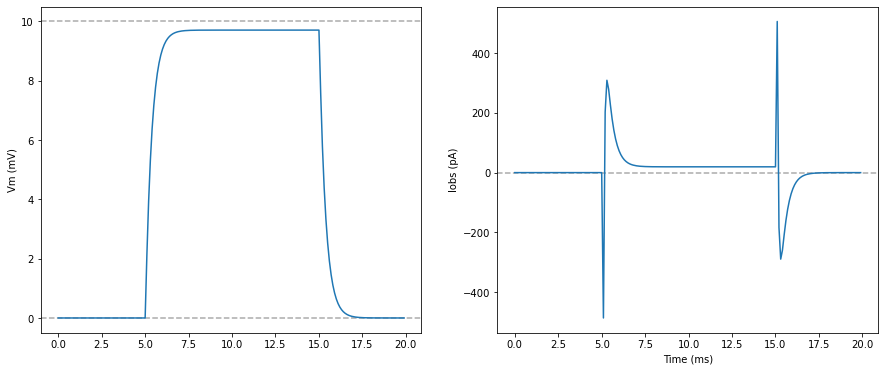

In [21]:
s = myokit.Simulation(m, p)
s.pre(5)
d = s.run(20, log_interval=0.1).npview()

fig, ax1, ax2 = create_plot('Vm (mV)', av1=[0, 10], av2=[0])
ax1.plot(d.time(), d['amp.Vm'])
ax2.plot(d.time(), d['amp.I_obs'])
plt.show()

Boom! We see large capacitative artefacts in the current signal.

On the left, we've switched from plotting $V_p$ to plotting $V_m$.
Note that neither is available in a real experiment.

## Slow capacitance cancellation

Although we see minor oscillations, we resist the urge to mess with the fast transient cancellation at this point, and move on to the slow capacitance cancellation.

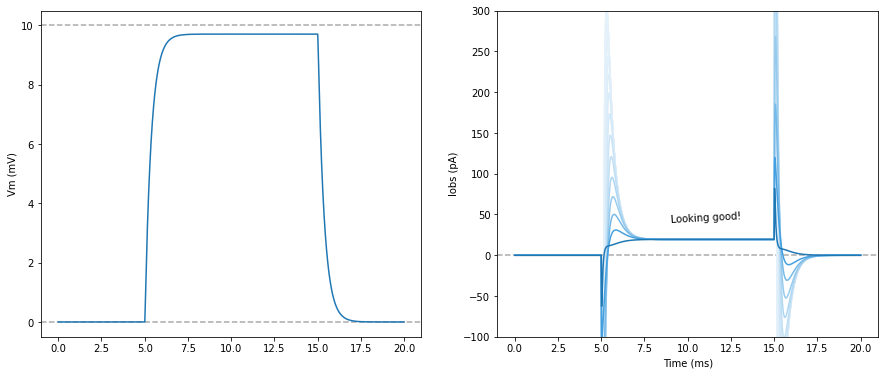

In [22]:
fig, ax1, ax2 = create_plot('Vm (mV)', av1=[0, 10], av2=[0, 2000])
for Cm_est in np.geomspace(1, 26, 20) - 1:
    s.reset()
    s.set_constant('amp.Cm_est', Cm_est)
    s.pre(5)
    d = s.run(20, log_interval=1e-3)  
    ax2.plot(d.time(), d['amp.I_obs'], color=blue(0.1 + 0.9 * (Cm_est / 25)**2))
ax1.plot(d.time(), d['amp.Vm'])
ax2.set_ylim(-100, 300)
ax2.text(9, 40, 'Looking good!', rotation=3)
plt.show()

Let's adjust the zoom and look at the result:

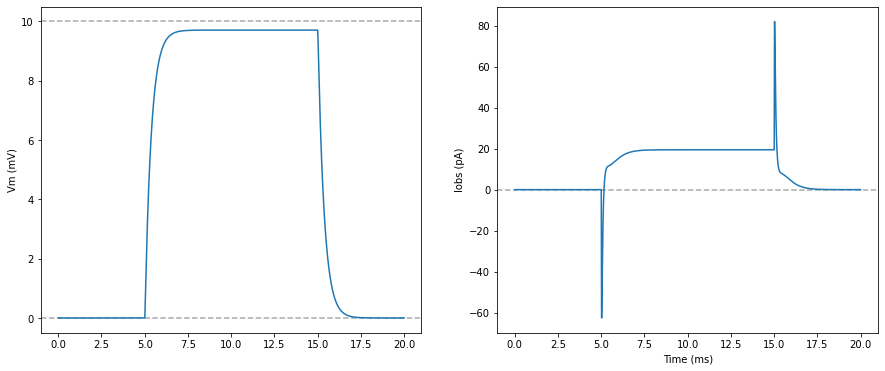

In [23]:
fig, ax1, ax2 = create_plot('Vm (mV)', av1=[0, 10], av2=[0])
ax1.plot(d.time(), d['amp.Vm'])
ax2.plot(d.time(), d['amp.I_obs'])
plt.show()

At this point, we might want to slightly under-correct the signal:

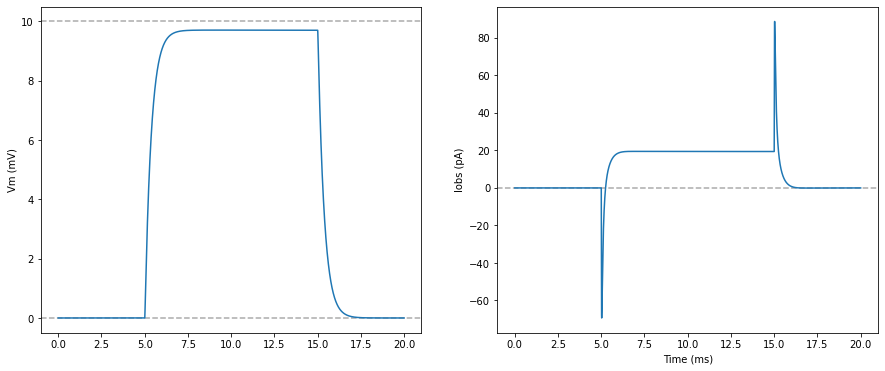

In [24]:
s.reset()
s.set_constant('amp.Cm_est', 24)
s.pre(5)
d = s.run(20, log_interval=1e-3)  

fig, ax1, ax2 = create_plot('Vm (mV)', av1=[0, 10], av2=[0])
ax1.plot(d.time(), d['amp.Vm'])
ax2.plot(d.time(), d['amp.I_obs'])
plt.show()

## Series resistance correction

Having set $C_m^*$, we move on to series resistance correction.

## Conclusion